# Setup

In [1]:
import sys
assert sys.version_info >= (3, 8)

import cv2 as cv
import numpy as np

if not cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

True

In [2]:
# import some other external libraries
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
import matplotlib.pyplot as plt

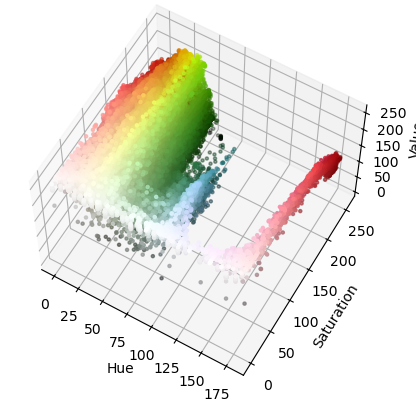

In [6]:
# Read the image
img = cv.imread('apple4.jpg')

if img is None:
    print("Error: Image not loaded. Check the file path.")
else:
    # Make a copy of the image
    img_copy = img.copy()

    # Convert the copied image to HSV
    hsv_img = cv.cvtColor(img_copy, cv.COLOR_BGR2HSV)

    # Extract HSV channels
    h, s, v = cv.split(hsv_img)

    # Convert HSV to RGB for pixel colors
    pixel_colors = cv.cvtColor(hsv_img, cv.COLOR_HSV2RGB)

    # Flatten the arrays for plotting
    h_flat = h.ravel()
    s_flat = s.ravel()
    v_flat = v.ravel()
    pixel_colors_flat = pixel_colors.reshape((-1, 3)) / 255.0  # Normalize to [0, 1]

    # Create 3D scatter plot
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")

    axis.scatter(h_flat, s_flat, v_flat,
                 facecolors=pixel_colors_flat, marker=".")
    axis.view_init(elev=60, azim=300)
    axis.set_xlabel("Hue")
    axis.set_ylabel("Saturation")
    axis.set_zlabel("Value")

    plt.show()

Image 1 bounding boxes (Green):
  Bounding box: x1=107, y1=70, x2=191, y2=160
Image 1 bounding boxes (Red):
  Bounding box: x1=40, y1=67, x2=117, y2=148
Image 2 bounding boxes (Green):
  Bounding box: x1=133, y1=35, x2=251, y2=149
Image 2 bounding boxes (Red):
  Bounding box: x1=8, y1=15, x2=128, y2=149
Image 3 bounding boxes (Green):
  Bounding box: x1=58, y1=109, x2=136, y2=187
Image 3 bounding boxes (Red):
  Bounding box: x1=123, y1=69, x2=204, y2=148
Image 4 bounding boxes (Green):
  Bounding box: x1=0, y1=0, x2=271, y2=186
  Bounding box: x1=148, y1=0, x2=271, y2=124
Image 4 bounding boxes (Red):
  Bounding box: x1=120, y1=54, x2=172, y2=130
Image 5 bounding boxes (Green):
  Bounding box: x1=0, y1=0, x2=167, y2=182
  Bounding box: x1=180, y1=0, x2=276, y2=182
Image 5 bounding boxes (Red):
  Bounding box: x1=164, y1=57, x2=235, y2=104
  Bounding box: x1=92, y1=78, x2=142, y2=113


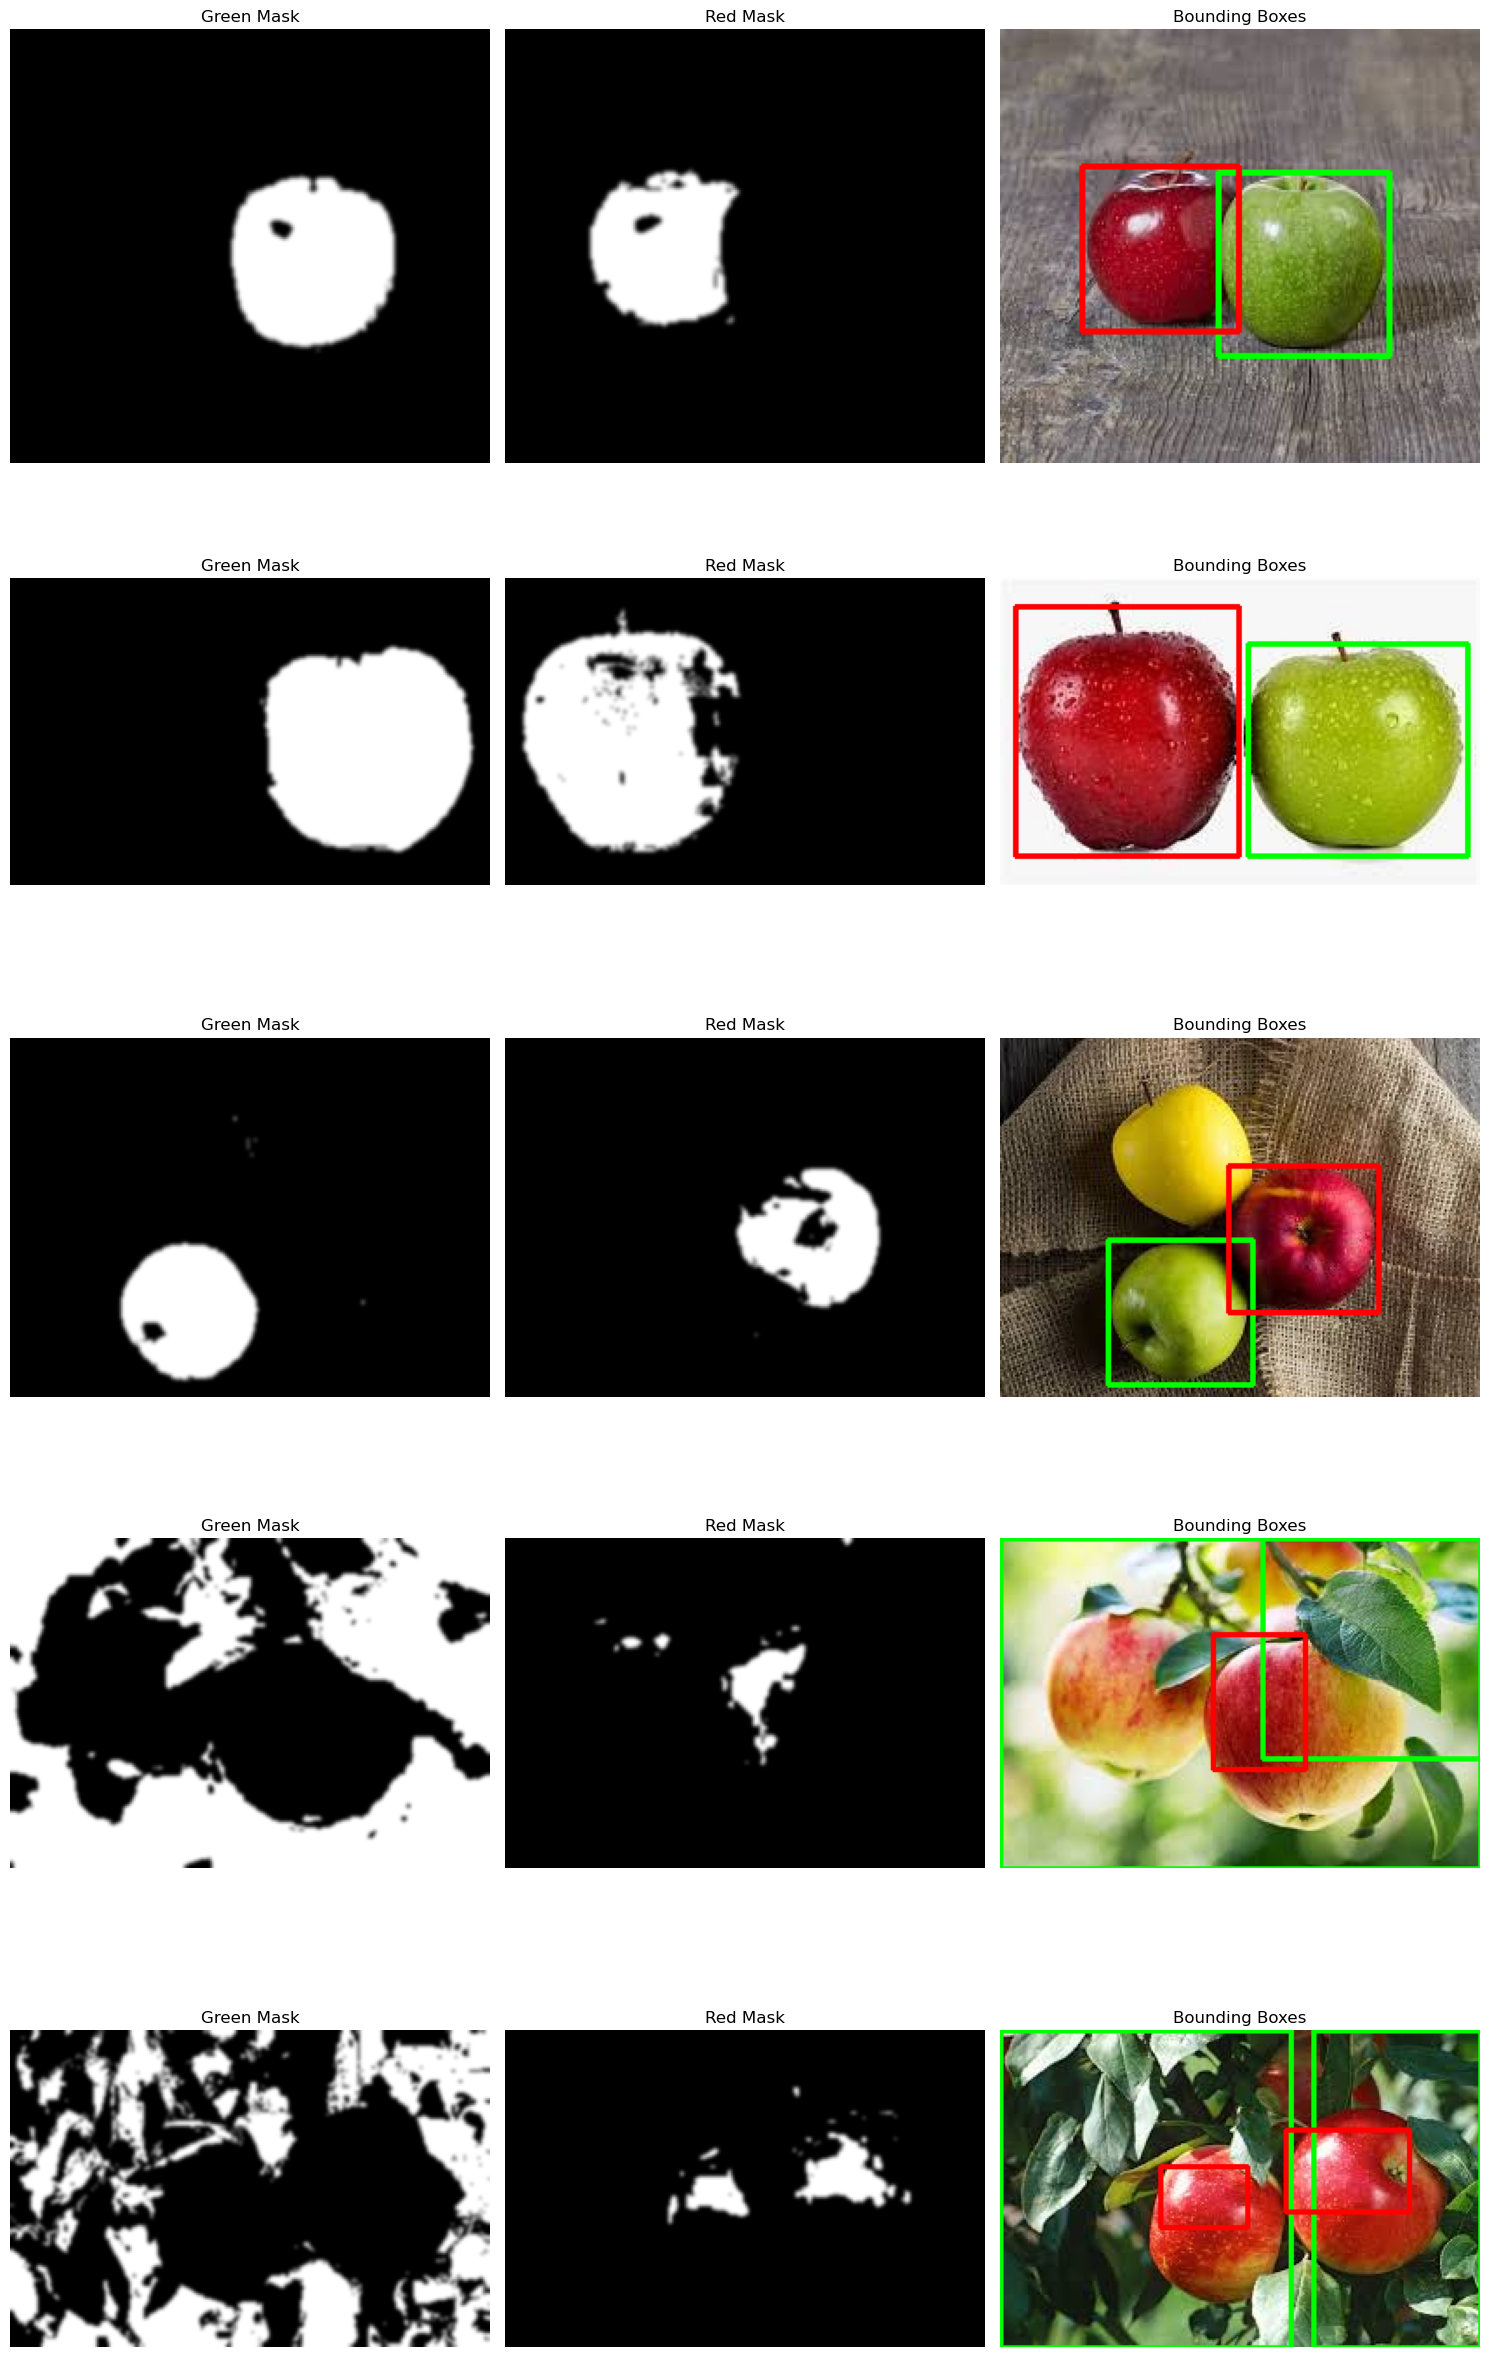

Stored Bounding Boxes:
Image 1:
  Green Bounding Boxes: [(107, 70, 191, 160)]
  Red Bounding Boxes: [(40, 67, 117, 148)]
Image 2:
  Green Bounding Boxes: [(133, 35, 251, 149)]
  Red Bounding Boxes: [(8, 15, 128, 149)]
Image 3:
  Green Bounding Boxes: [(58, 109, 136, 187)]
  Red Bounding Boxes: [(123, 69, 204, 148)]
Image 4:
  Green Bounding Boxes: [(0, 0, 271, 186), (148, 0, 271, 124)]
  Red Bounding Boxes: [(120, 54, 172, 130)]
Image 5:
  Green Bounding Boxes: [(0, 0, 167, 182), (180, 0, 276, 182)]
  Red Bounding Boxes: [(164, 57, 235, 104), (92, 78, 142, 113)]


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def color_segment(img, hue_range, smooth=True):
    """
    Perform color-based segmentation on the input image.
    
    Arguments:
    ---
    img : numpy.ndarray
        The source image in RGB format.
    hue_range : tuple
        A tuple specifying the range of hues to segment (e.g., (30, 90) for green).
    smooth : bool, optional
        Whether to apply Gaussian blurring to the mask (default is True).
    
    Returns:
    ---
    numpy.ndarray
        The binary mask image where the selected color range is highlighted.
    """

    # Convert the image to HSV
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Split the HSV image into its channels
    h, s, v = cv2.split(hsv_img)

    # Find the min and max values of Hue in the ranges
    def get_range(hue_channel, hue_range):
        min_hue = np.min(hue_channel[(hue_channel >= hue_range[0]) & (hue_channel <= hue_range[1])])
        max_hue = np.max(hue_channel[(hue_channel >= hue_range[0]) & (hue_channel <= hue_range[1])])
        return min_hue, max_hue

    def get_value_range(value_channel):
        min_value = np.min(value_channel)
        max_value = np.max(value_channel)
        return min_value, max_value

    # Get the hue range for the specified color
    min_hue, max_hue = get_range(h, hue_range)
    min_value, max_value = get_value_range(v)

    # Define the color ranges for mask creation
    low_col = np.array([min_hue, 50, 50])  # Lower bound for color
    high_col = np.array([max_hue, 255, 255])  # Upper bound for color

    # Create the mask
    mask = cv2.inRange(hsv_img, low_col, high_col)

    if smooth:
        mask = cv2.GaussianBlur(mask, (5, 5), 0)

    return mask

def get_bounding_boxes(mask, min_area=500):
    """Extract bounding boxes from a binary mask, filtering by minimum area."""
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bbs = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if (w * h) >= min_area:
            bbs.append((x, y, x + w, y + h))
    return bbs

# Define green and red ranges in Hue channel
green_range = (30, 90)
red_range = (165, 180)  # Only using this range for red

imgs = []

for i in range(1, 6):
    img_pant = cv2.imread(f"apple{i}.jpg")
    img_pant = cv2.cvtColor(img_pant, cv2.COLOR_BGR2RGB)
    imgs.append(img_pant)

results = []
for img in imgs:
    mask_green = color_segment(img, green_range)
    mask_red = color_segment(img, red_range)
    
    bounding_boxes_green = get_bounding_boxes(mask_green, min_area=500)
    bounding_boxes_red = get_bounding_boxes(mask_red, min_area=500)
    
    # Apply the masks to the image
    res_green = cv2.bitwise_and(img, img, mask=mask_green)
    res_red = cv2.bitwise_and(img, img, mask=mask_red)
    
    # Get the first two bounding boxes for each color
    bbs_green = sorted(bounding_boxes_green, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]), reverse=True)[:2]
    bbs_red = sorted(bounding_boxes_red, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]), reverse=True)[:2]
    
    results.append((mask_green, res_green, bbs_green, mask_red, res_red, bbs_red))

# Store bounding boxes in list
bounding_box_list = []
for i, (mask_green, res_green, bbs_green, mask_red, res_red, bbs_red) in enumerate(results):
    bounding_box_list.append({
        'image': i + 1,
        'green_bbs': bbs_green,
        'red_bbs': bbs_red
    })

# Show the results
fig, axes = plt.subplots(len(results), 3, figsize=(15, 5 * len(results)))
for i, (mask_green, res_green, bbs_green, mask_red, res_red, bbs_red) in enumerate(results):
    # Display green mask
    axes[i][0].imshow(mask_green, cmap='gray')
    axes[i][0].set_title("Green Mask")
    axes[i][0].axis('off')
    
    # Display red mask
    axes[i][1].imshow(mask_red, cmap='gray')
    axes[i][1].set_title("Red Mask")
    axes[i][1].axis('off')
    
    # Display results with bounding boxes
    display_img = np.copy(imgs[i])
    for box in bbs_green:
        x1, y1, x2, y2 = box
        cv2.rectangle(display_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green bounding box
    
    for box in bbs_red:
        x1, y1, x2, y2 = box
        cv2.rectangle(display_img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red bounding box
    
    axes[i][2].imshow(display_img)
    axes[i][2].set_title("Bounding Boxes")
    axes[i][2].axis('off')

    # Print bounding box positions
    print(f"Image {i + 1} bounding boxes (Green):")
    for box in bbs_green:
        print(f"  Bounding box: x1={box[0]}, y1={box[1]}, x2={box[2]}, y2={box[3]}")
    
    print(f"Image {i + 1} bounding boxes (Red):")
    for box in bbs_red:
        print(f"  Bounding box: x1={box[0]}, y1={box[1]}, x2={box[2]}, y2={box[3]}")

plt.tight_layout()
plt.show()

# Print the stored bounding box list
print("Stored Bounding Boxes:")
for entry in bounding_box_list:
    print(f"Image {entry['image']}:")
    print("  Green Bounding Boxes:", entry['green_bbs'])
    print("  Red Bounding Boxes:", entry['red_bbs'])



In [4]:
import cv2 as cv

# Initialize a list to store bounding boxes for each image
all_bounding_boxes = []

# Loop through all 5 images
for i in range(1, 6):
    # Load the image
    img_path = f"apple{i}.jpg"
    img = cv.imread(img_path)

    if img is None:
        print(f"Error: Image {img_path} not found or failed to load.")
        continue

    # Allow the user to select two bounding boxes
    print(f"Please select two bounding boxes for {img_path}. Press Enter after each selection.")
    
    bbs = []
    for j in range(2):  # Loop to get two bounding boxes
        bb = cv.selectROI("bounding box", img, showCrosshair=False, fromCenter=False)
        if bb != (0, 0, 0, 0):  # Check if a bounding box was selected
            x, y, w, h = bb
            x2, y2 = x + w, y + h
            bbs.append((x, y, x2, y2))  # Convert to (x1, y1, x2, y2)
            print(f"Selected bounding box {j + 1}: x={x}, y={y}, w={w}, h={h}")
        else:
            print(f"No bounding box selected for {img_path}.")

    # Store bounding boxes for the current image
    if len(bbs) == 2:  # Check if exactly two bounding boxes were selected
        all_bounding_boxes.append(bbs)
    else:
        print(f"Not enough bounding boxes selected for {img_path}. Skipping.")

    # Close the window after selection
    cv.destroyAllWindows()

# Print all bounding boxes for all images
print("\nAll Bounding Boxes:")
for i, boxes in enumerate(all_bounding_boxes, start=1):
    print(f"Image {i}:")
    for j, box in enumerate(boxes, start=1):
        print(f"  Bounding box {j}: x1={box[0]}, y1={box[1]}, x2={box[2]}, y2={box[3]}")



Please select two bounding boxes for apple1.jpg. Press Enter after each selection.
Selected bounding box 1: x=38, y=61, w=79, h=86
Selected bounding box 2: x=107, y=66, w=85, h=93
Please select two bounding boxes for apple2.jpg. Press Enter after each selection.
Selected bounding box 1: x=11, y=19, w=117, h=129
Selected bounding box 2: x=131, y=29, w=119, h=118
Please select two bounding boxes for apple3.jpg. Press Enter after each selection.
Selected bounding box 1: x=59, y=107, w=76, h=79
Selected bounding box 2: x=126, y=62, w=75, h=87
Please select two bounding boxes for apple4.jpg. Press Enter after each selection.
Selected bounding box 1: x=27, y=37, w=95, h=100
Selected bounding box 2: x=113, y=55, w=119, h=111
Please select two bounding boxes for apple5.jpg. Press Enter after each selection.
Selected bounding box 1: x=79, y=65, w=87, h=91
Selected bounding box 2: x=164, y=44, w=92, h=101

All Bounding Boxes:
Image 1:
  Bounding box 1: x1=38, y1=61, x2=117, y2=147
  Bounding box

In [5]:
import cv2 as cv
import numpy as np

def compute_metrics(boxA, boxB):
    """
    Computes the Intersection over Union (IoU) and Dice coefficient between two bounding boxes.

    Arguments:
    ---
    boxA: tuple (x1, y1, x2, y2) representing the first bounding box.
    boxB: tuple (x1, y1, x2, y2) representing the second bounding box.

    Returns:
    ---
    iou: Intersection over Union (IoU) between the two bounding boxes.
    dice: Dice coefficient between the two bounding boxes.
    """
    # Compute intersection coordinates
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1])
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3])

    # Intersection area
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Areas of both rectangles
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # IOU and Dice calculations
    iou = interArea / float(areaA + areaB - interArea)
    dice = 2 * interArea / float(areaA + areaB)

    return iou, dice

def draw_boxes(img, boxes, color, label):
    for (x1, y1, x2, y2) in boxes:
        cv.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv.putText(img, label, (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

# Iterate through the images and print IoU and Dice coefficients
for i, boxes in enumerate(all_bounding_boxes):
    img_path = f"apple{i + 1}.jpg"
    img = cv.imread(img_path)

    if img is None:
        print(f"Error: Image {img_path} not found or failed to load.")
        continue

    green_boxes = bounding_box_list[i]['green_bbs']
    red_boxes = bounding_box_list[i]['red_bbs']

    for j, box in enumerate(boxes):
        results = []
        for g_box in green_boxes:
            iou, dice = compute_metrics(box, g_box)
            results.append((iou, dice, "Green Box", g_box))

        for r_box in red_boxes:
            iou, dice = compute_metrics(box, r_box)
            results.append((iou, dice, "Red Box", r_box))

        # Sort by IoU first, then by Dice if IoU values are the same
        results.sort(key=lambda x: (x[0], x[1]), reverse=True)

        # Draw the top result on the image
        for idx, (iou, dice, box_type, best_box) in enumerate(results[:1], 1):
            if box_type == "Green Box":
                draw_boxes(img, [best_box], (0, 255, 0), "Green")
            else:
                draw_boxes(img, [best_box], (255, 0, 0), "Red")

            print(f"Image {i + 1}, Box {j + 1} vs {box_type} (Top {idx}): IoU = {iou:.4f}, Dice = {dice:.4f}")

    # Display the image with bounding boxes
    cv.imshow(f"Image {i + 1}", img)
    cv.waitKey(0)
    cv.destroyAllWindows()


Image 1, Box 1 vs Red Box (Top 1): IoU = 0.8965, Dice = 0.9454
Image 1, Box 2 vs Green Box (Top 1): IoU = 0.9358, Dice = 0.9668
Image 2, Box 1 vs Red Box (Top 1): IoU = 0.9386, Dice = 0.9683
Image 2, Box 2 vs Green Box (Top 1): IoU = 0.9106, Dice = 0.9532
Image 3, Box 1 vs Green Box (Top 1): IoU = 0.9384, Dice = 0.9682
Image 3, Box 2 vs Red Box (Top 1): IoU = 0.8465, Dice = 0.9169
Image 4, Box 1 vs Green Box (Top 1): IoU = 0.1885, Dice = 0.3172
Image 4, Box 2 vs Red Box (Top 1): IoU = 0.2941, Dice = 0.4545
Image 5, Box 1 vs Green Box (Top 1): IoU = 0.2605, Dice = 0.4133
Image 5, Box 2 vs Green Box (Top 1): IoU = 0.4021, Dice = 0.5736
